In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [4]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"Loaded {len(dfs)} recordings")
    return dfs


def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)


def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]


def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    print(f"Built dataset: {X.shape}")
    return X, y, groups
class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
class DeepConvLSTM(nn.Module):
    def __init__(self, input_features, num_classes, dropout=0.3):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(input_features, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)

        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

In [8]:
def train_fold(X_train, y_train, X_val, y_val, le):

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)

    X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    y_train = le.transform(y_train)
    y_val = le.transform(y_val)

    train_loader = DataLoader(MotionDataset(X_train, y_train),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val),
                            batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DeepConvLSTM(
        input_features=X_train.shape[2],
        num_classes=len(le.classes_),
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=10
    )

    best_loss = np.inf
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                val_loss += criterion(out, yb).item() * xb.size(0)
                preds.extend(out.argmax(1).cpu().numpy())
                trues.extend(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return trues, preds

def evaluate_model(X, y, groups, title):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    cv = GroupKFold(n_splits=5)
    y_true_all, y_pred_all = [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded, groups), 1):
        print(f"\n=== Fold {fold} ===")
        y_true, y_pred = train_fold(
            X[train_idx], y[train_idx],
            X[val_idx], y[val_idx],
            le
        )
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all,
                                target_names=le.classes_, digits=4))

    cm = confusion_matrix(y_true_all, y_pred_all)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Oranges")
    plt.title(title)
    plt.show()

Loaded 100 recordings
Built dataset: (5025, 100, 6)

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== Deep Conv-LSTM (RAW) ===
              precision    recall  f1-score   support

         run     0.9992    0.9864    0.9928      1250
         sit     0.9849    0.9912    0.9880      1250
      stairs     0.9673    0.9498    0.9584      1275
        walk     0.9399    0.9632    0.9514      1250

    accuracy                         0.9725      5025
   macro avg     0.9728    0.9727    0.9727      5025
weighted avg     0.9728    0.9725    0.9726      5025



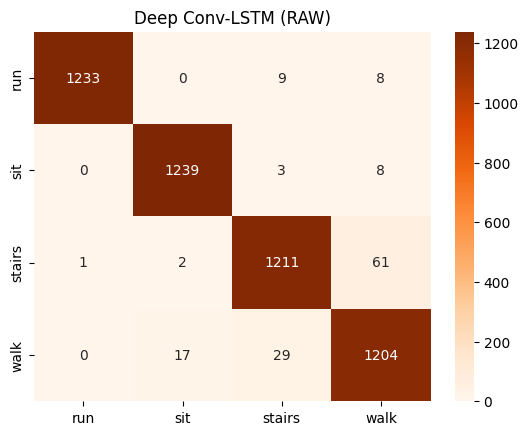

Built dataset: (5025, 100, 6)

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== Deep Conv-LSTM (GFT) ===
              precision    recall  f1-score   support

         run     0.9992    0.9872    0.9932      1250
         sit     0.9810    0.9928    0.9869      1250
      stairs     0.9486    0.9263    0.9373      1275
        walk     0.9234    0.9456    0.9344      1250

    accuracy                         0.9628      5025
   macro avg     0.9631    0.9630    0.9629      5025
weighted avg     0.9630    0.9628    0.9628      5025



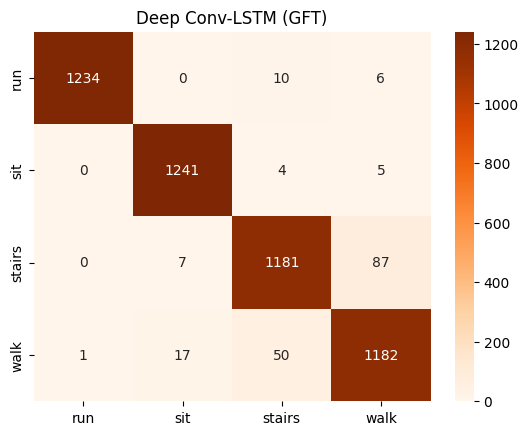

In [9]:
if __name__ == "__main__":

    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw = build_dataset(recordings, RAW_FEATURES)
    evaluate_model(X_raw, y_raw, g_raw, "Deep Conv-LSTM (RAW)")

    X_gft, y_gft, g_gft = build_dataset(recordings, GFT_FEATURES)
    evaluate_model(X_gft, y_gft, g_gft, "Deep Conv-LSTM (GFT)")